In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
tqdm.pandas()

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')
from sentence_transformers import SentenceTransformer


from matplotlib.cm import get_cmap
import umap
from sklearn.preprocessing import LabelEncoder


from src.utils import split_data, wiki_intro, get_categories

[nltk_data] Downloading package punkt_tab to /home/ivan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv('../resources/dataset.csv')
categories_df = pd.read_csv('../resources/categories.csv')

In [3]:
categories = get_categories(categories_df)

In [4]:
# df['DESCRIPTION'] = df['COMPANY'].progress_apply(lambda x: wiki_intro(x))
# df.to_csv('../resources/dataset_with_descriptions.csv', index=False)
df = pd.read_csv('../resources/dataset_with_descriptions.csv')
len(df)

2000

In [5]:
df.head()

,COMPANY,CATEGORY,DESCRIPTION
0,Citigroup,Banking,Citigroup Inc. or Citi (stylized as citi) is a...
1,General Electric,Conglomerates,General Electric Company (GE) was an American ...
2,American Intl Group,Insurance,"American International Group, Inc. (AIG) is an..."
3,ExxonMobil,Oil & gas operations,Exxon Mobil Corporation ( EK-son-MOH-bəl) is a...
4,BP,Oil & gas operations,BP p.l.c. (formerly The British Petroleum Comp...


For demo purposes I'm using SentenceTransformer which is capable of only couple sentences. And produces 384 dimensional vectors. In reality, we will be using more powerful encoder.

We only take the first 2 sentences.

In [6]:
def first_n_sentences(text, n=2):
    sentences = sent_tokenize(text)
    if len(sentences) > n:
        return ' '.join(sentences[:n])
    else:
        return text
    

In [7]:
df['DESCRIPTION'] = df['DESCRIPTION'].fillna('')

In [8]:
df['DESCRIPTION_SHORT'] = df['DESCRIPTION'].progress_apply(lambda x: first_n_sentences(x, n=2))

100%|██████████| 2000/2000 [00:00<00:00, 8133.01it/s]


In [9]:
encoder = SentenceTransformer('all-MiniLM-L6-v2')

In [10]:
embeddings_name = encoder.encode(df['COMPANY'])

In [11]:
embeddings_description_short = encoder.encode(df['DESCRIPTION_SHORT'])

In [12]:
df['EMBEDDING_NAME'] = embeddings_name.tolist()
df['EMBEDDING_DESCRIPTION_SHORT'] = embeddings_description_short.tolist()

In [13]:
# combine embeddings by adding them
df['EMBEDDING_FULL_AVG'] = df.apply(
    lambda x: np.mean([np.array(x['EMBEDDING_NAME']), 
                       np.array(x['EMBEDDING_DESCRIPTION_SHORT'])
                       ], axis=0).tolist(),
    axis=1
)

In [14]:
df['EMBEDDING_FULL_CAT'] = df['EMBEDDING_NAME'] + df['EMBEDDING_DESCRIPTION_SHORT']

In [15]:
len(df['EMBEDDING_FULL_CAT'][0]) /2

384.0

Lets plot the embeddings in a lower dimensional space to see if there are any cluster-like structures between the different classes.

In [16]:
def plot_umap(embeddings, labels, title):
    # Convert labels to a numeric form for coloring if needed
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    unique_labels = label_encoder.classes_

    # UMAP projection
    reducer = umap.UMAP(n_neighbors=10, n_components=2, metric='cosine', random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    # Choose a colormap that supports many discrete categories
    num_categories = len(unique_labels)
    cmap = get_cmap('tab20b' if num_categories > 20 else 'tab20', num_categories)
    colors = [cmap(i) for i in range(num_categories)]

    plt.figure(figsize=(12, 10))
    for i, label in enumerate(unique_labels):
        idx = labels_encoded == i
        plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1],
                    color=colors[i], label=label, alpha=0.7, s=60, edgecolor='k', linewidth=0.2)

    plt.title(title, fontsize=16)
    plt.xlabel('UMAP 1', fontsize=13)
    plt.ylabel('UMAP 2', fontsize=13)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Categories', fontsize=10, title_fontsize=11)
    plt.tight_layout()
    plt.grid(False)
    # plt.show()

/home/ivan/FRI/2024-2025/celtra_stuff/clean_venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ivan/FRI/2024-2025/celtra_stuff/clean_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_573253/2880062086.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20b' if num_categories > 20 else 'tab20', num_categories)


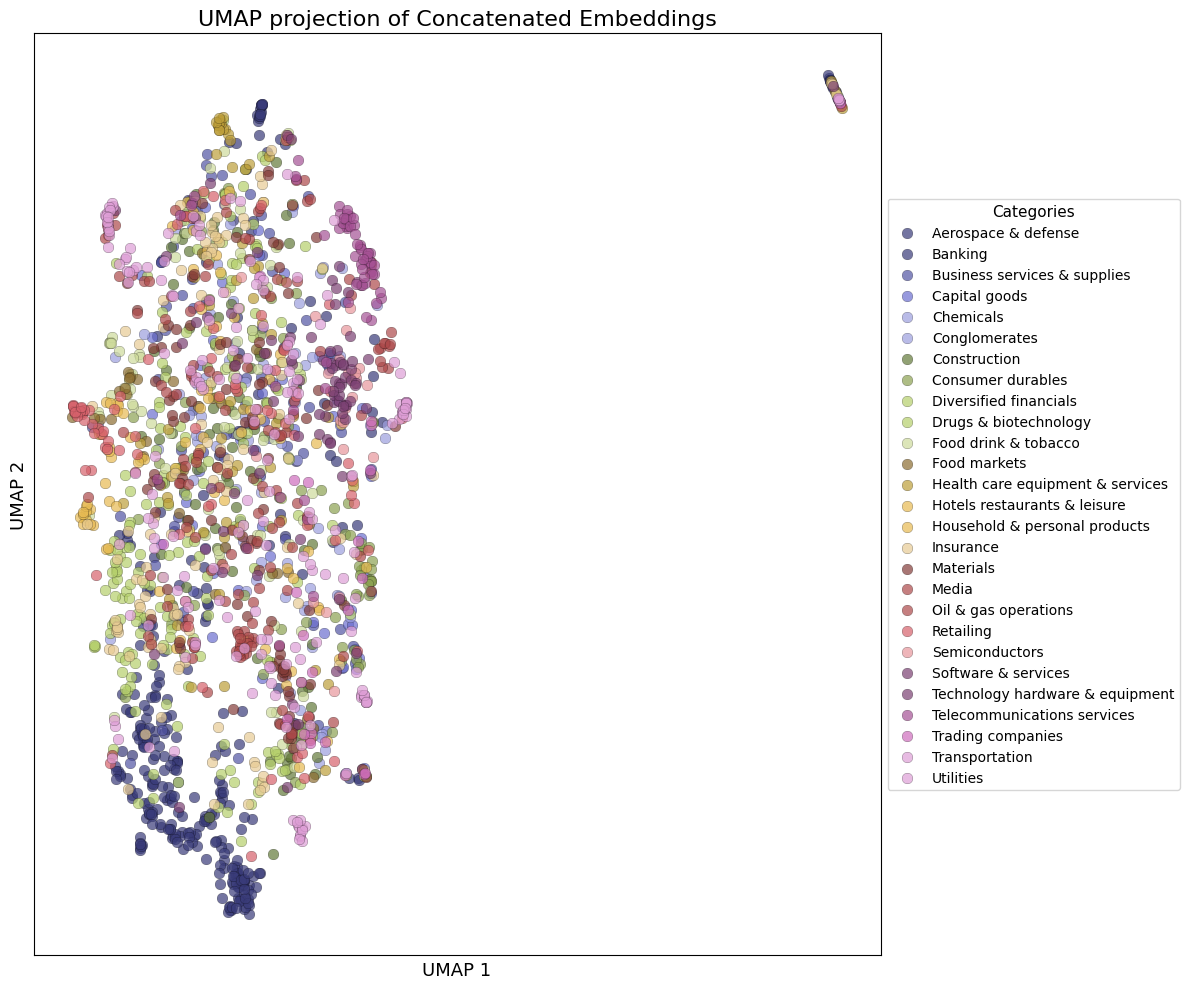

In [17]:
plot_umap(
    df['EMBEDDING_FULL_CAT'].tolist(), 
    df['CATEGORY'].tolist(), 
    'UMAP projection of Concatenated Embeddings'
)
plt.savefig('../img/umap_concat.svg', dpi=300, bbox_inches='tight')

/home/ivan/FRI/2024-2025/celtra_stuff/clean_venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ivan/FRI/2024-2025/celtra_stuff/clean_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_573253/2880062086.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20b' if num_categories > 20 else 'tab20', num_categories)


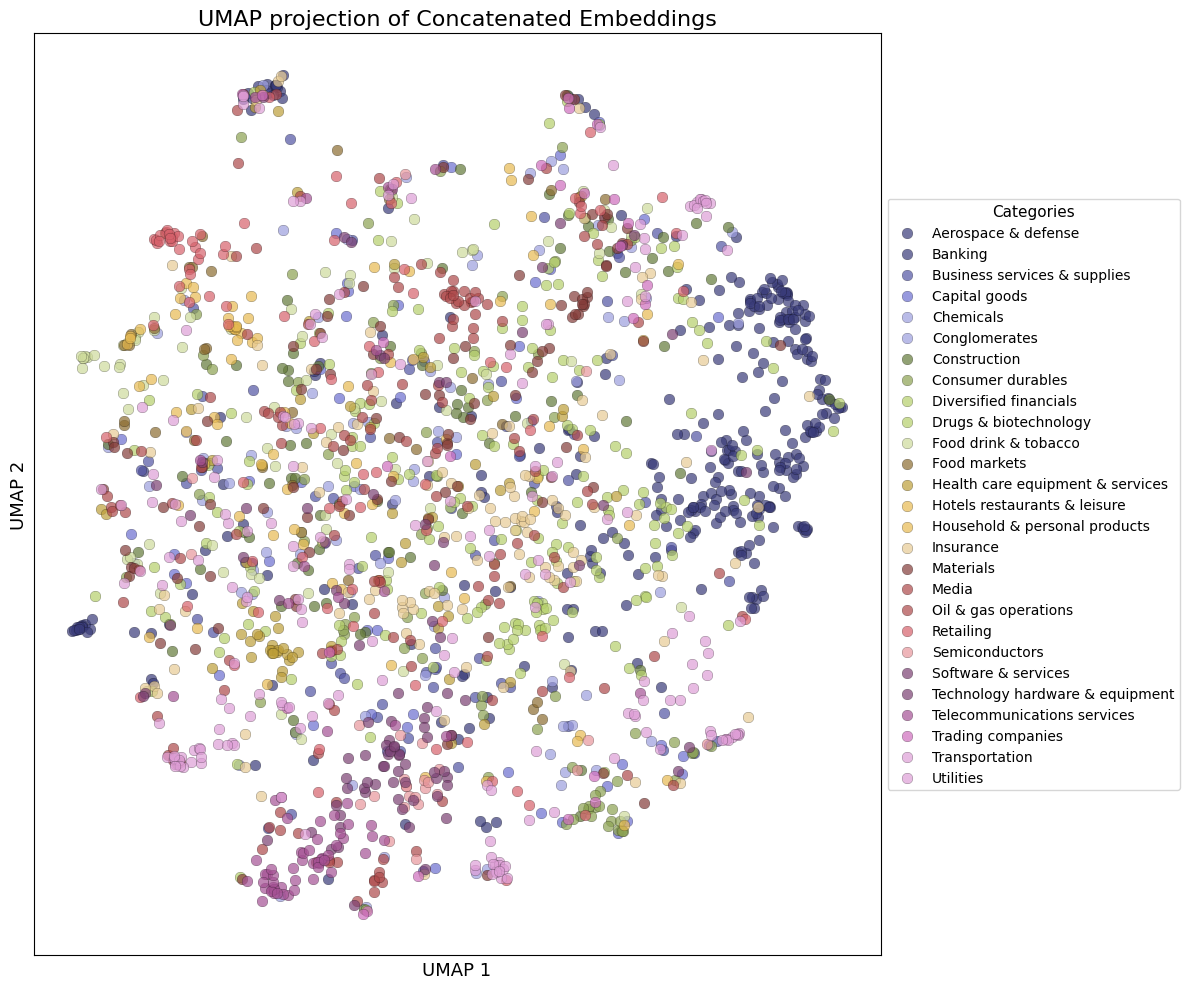

In [18]:
plot_umap(
    df['EMBEDDING_FULL_AVG'].tolist(), 
    df['CATEGORY'].tolist(), 
    'UMAP projection of Concatenated Embeddings'
)
plt.savefig('../img/umap_avg.svg', dpi=300, bbox_inches='tight')

From the embeddings plotted in two dimensional space it seems that there isn't any nice grouping / clustering of the different categories. 

## Classifier

For this part for simplicity I chose XGBoost, however any other classifier can be trained (multi-layer perceptron, SVM, categorical regression etc.)

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

In [20]:
label_encoder = LabelEncoder()
df['CATEGORY_INT'] = label_encoder.fit_transform(df['CATEGORY'])

In [21]:
train_df, test_df = split_data(df)
len(train_df), len(test_df)

(1400, 600)

In [22]:
X_train_avg = np.array(train_df['EMBEDDING_FULL_AVG'].tolist())
X_train_cat = np.array(train_df['EMBEDDING_FULL_CAT'].tolist())
y_train = np.array(train_df['CATEGORY_INT'].tolist())
X_test_avg = np.array(test_df['EMBEDDING_FULL_AVG'].tolist())
X_test_cat = np.array(test_df['EMBEDDING_FULL_CAT'].tolist())
y_test = np.array(test_df['CATEGORY_INT'].tolist())

In [23]:
X_train_avg.shape, X_train_cat.shape, y_train.shape, X_test_avg.shape, X_test_cat.shape, y_test.shape

((1400, 384), (1400, 768), (1400,), (600, 384), (600, 768), (600,))

Because the class distribution is unbalanced, I weighted the loss-function.

In [24]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
xgb_model = xgb.XGBClassifier( eval_metric='mlogloss')
xgb_model.fit(X_train_avg, y_train, sample_weight=sample_weights)
xgb_model_cat = xgb.XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
xgb_model_cat.fit(X_train_cat, y_train, sample_weight=sample_weights)

/home/ivan/FRI/2024-2025/celtra_stuff/clean_venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:21:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
y_pred_avg = xgb_model.predict(X_test_avg)
y_pred_cat = xgb_model_cat.predict(X_test_cat)
accuracy_avg = accuracy_score(y_test, y_pred_avg)
accuracy_cat = accuracy_score(y_test, y_pred_cat)

In [26]:
print(f"Accuracy with avg embedding: {accuracy_avg: .4f}")
print(f"Accuracy with concat embedding: {accuracy_cat: .4f}")

Accuracy with avg embedding:  0.4217
Accuracy with concat embedding:  0.4483


In [27]:
from src.eval import calculate_metrics, calculate_ste_metrics_with_bootstrap

In [28]:
metrics_avg = calculate_metrics(y_test, y_pred_avg)
metrics_cat = calculate_metrics(y_test, y_pred_cat)

ste_avg = calculate_ste_metrics_with_bootstrap(y_test, y_pred_avg)
ste_cat = calculate_ste_metrics_with_bootstrap(y_test, y_pred_cat)

In [29]:
# print nicely the results with bootstrap standard errors
for key in metrics_avg.keys():
    print(f"{key}: {metrics_avg[key]:.4f} ± {ste_avg[key]:.4f} (avg)")
    print(f"{key}: {metrics_cat[key]:.4f} ± {ste_cat[key]:.4f} (concat)")
    print()

f1: 0.4108 ± 0.0201 (avg)
f1: 0.4372 ± 0.0211 (concat)

precision: 0.2972 ± 0.0180 (avg)
precision: 0.3652 ± 0.0233 (concat)

recall: 0.3056 ± 0.0176 (avg)
recall: 0.3511 ± 0.0212 (concat)

accuracy: 0.4217 ± 0.0198 (avg)
accuracy: 0.4483 ± 0.0202 (concat)



In [30]:
from src.classify_emb import EmbeddingClassifier

embedding_classifier = EmbeddingClassifier(
    encoder=SentenceTransformer('all-MiniLM-L6-v2'),
    classifier=xgb_model_cat,
    class_map=label_encoder.classes_,
    agg='cat'
)



In [31]:
embedding_classifier.categorize('Walmart'), embedding_classifier.categorize_get_description('Walmart', wiki_intro)

('Health care equipment & services', 'Retailing')

Ideally we would do GridSearch or some other hyper-parameter tuning technique with cross-validation on the training set to find the best hyperparameter combination.

The code below was not ran because it would take a lot of time.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    refit=True,
    cv=10,
    n_jobs=-1,
    verbose=2
)

# Train on both embedding types
print("Running grid search on EMBEDDING_FULL_AVG...")
grid_search.fit(X_train_avg, y_train, sample_weight=sample_weights)
print(f"Best parameters for EMBEDDING_FULL_AVG: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")

# Save best model for FULL_AVG
best_model_avg = grid_search.best_estimator_

print("\nRunning grid search on EMBEDDING_FULL_CAT...")
grid_search.fit(X_train_cat, y_train, sample_weight=sample_weights)
print(f"Best parameters for EMBEDDING_FULL_CAT: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")

# Save best model for FULL_CAT
best_model_cat = grid_search.best_estimator_

# Evaluate on test set
y_pred_avg_best = best_model_avg.predict(X_test_avg)
y_pred_cat_best = best_model_cat.predict(X_test_cat)

accuracy_avg_best = accuracy_score(y_test, y_pred_avg_best)
accuracy_cat_best = accuracy_score(y_test, y_pred_cat_best)

print("\nTest accuracy with optimized models:")
print(f"Accuracy with avg embedding (optimized): {accuracy_avg_best:.4f}")
print(f"Accuracy with concat embedding (optimized): {accuracy_cat_best:.4f}")
